## **Содержание**

В ходе занятия будет предложено реализовать программную реализацию алгоритма обратного распространения ошибки и обучение полносвязной нейронной сети без использования готовых фреймворков. Материалы занятия основаны на проекте https://github.com/karpathy/micrograd.

### **Класс Value**

Класс Value используется для хранения элемента (скаляра) и его градиента.

In [1]:
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self.grad = 0
        # внутренние переменные для backprop
        self._backward = lambda: None
        self._prev = set(_children)

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

Операция сложения:

In [2]:
def add_func(self, other):
    other = other if isinstance(other, Value) \
        else Value(other)
    out = Value(self.data + other.data, (self, other))

    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward

    return out

Value.__add__ = add_func
Value.__radd__ = lambda self, other: self + other

Операция умножения:

In [3]:
def mul_func(self, other):
    other = other if isinstance(other, Value) \
        else Value(other)
    out = Value(self.data * other.data, (self, other))

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

Value.__mul__ = mul_func
Value.__rmul__ = lambda self, other: self * other

Операция возведения в степень:

In [4]:
def pow_func(self, other):
    assert isinstance(other, (int, float)), \
        "only supporting int/float powers for now"
    out = Value(self.data**other, (self,))

    def _backward():
        self.grad += (other * self.data**(other-1)) \
            * out.grad
    out._backward = _backward

    return out

Value.__pow__ = pow_func

Оставшиеся арифметические операции определим как комбинации существующих:

In [5]:
# -self
Value.__neg__ = lambda self: self * -1
# self - other
Value.__sub__ = lambda self, other: self + (-other)
# other - self
Value.__rsub__ = lambda self, other: other + (-self)
# self / other
Value.__truediv__ = lambda self, other: self * other**-1
# other / self
Value.__rtruediv__ = lambda self, other: other * self**-1

Определим функцию активации ReLU:

In [6]:
def relu_func(self):
    out = Value(0 if self.data < 0 \
        else self.data, (self,))

    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward

    return out

Value.relu = relu_func

Для расчета градиентов необходимо в обратном порядке перебрать элементы графа вычисления. Для этого используется внутренняя переменная *_prev*.

In [7]:
def backward_func(self):

    # chainrule
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    # применение backprop согласно chainrule
    self.grad = 1
    for v in reversed(topo):
        v._backward()

Value.backward = backward_func

### Сравнение с torch.autograd

In [8]:
a = Value(2.0)
b = Value(3.0)
c = a * b
d = Value(5.0)
e = d * c
e.backward()

In [9]:
e.grad, d.grad, c.grad, b.grad, a.grad

(1, 6.0, 5.0, 10.0, 15.0)

In [10]:
import torch

In [11]:
x = Value(-4.0)
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backward()
xmg, ymg = x, y

x = torch.Tensor([-4.0]).double()
x.requires_grad = True
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backward()
xpt, ypt = x, y

# forward pass
assert ymg.data == ypt.data.item()
# backward pass
assert xmg.grad == xpt.grad.item()

print("passed all tests")

passed all tests


In [12]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backward()
amg, bmg, gmg = a, b, g

a = torch.Tensor([-4.0]).double()
b = torch.Tensor([2.0]).double()
a.requires_grad = True
b.requires_grad = True
c = a + b
d = a * b + b**3
c = c + c + 1
c = c + 1 + c + (-a)
d = d + d * 2 + (b + a).relu()
d = d + 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g = g + 10.0 / f
g.backward()
apt, bpt, gpt = a, b, g

tol = 1e-6
# forward pass
assert abs(gmg.data - gpt.data.item()) < tol
# backward pass
assert abs(amg.grad - apt.grad.item()) < tol
assert abs(bmg.grad - bpt.grad.item()) < tol

print("passed all tests")

passed all tests


### **Обучение MLP на основе класса Value**

In [13]:
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_moons, make_blobs

In [14]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

In [15]:
class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) 
            for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi 
            for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

In [16]:
class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs)
            for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [17]:
class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1)
            for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [18]:
seed = 2024
np.random.seed(seed)
random.seed(seed)

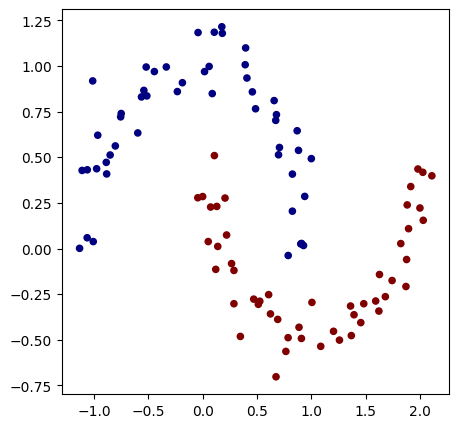

In [19]:
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [20]:
model = MLP(2, [16, 16, 1]) # 2-layer MLP
print("number of parameters", len(model.parameters()))

number of parameters 337


In [21]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() 
        for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0)
        for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9572657927863953, grad=0) 0.54


In [22]:
# optimization
for k in range(21):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 5 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9572657927863953, accuracy 54.0%
step 5 loss 0.3298985257023972, accuracy 86.0%
step 10 loss 0.23813563082520003, accuracy 88.0%
step 15 loss 0.4343065590980976, accuracy 86.0%
step 20 loss 0.1322928403578638, accuracy 97.0%


(-1.7023042238416939, 2.047695776158306)

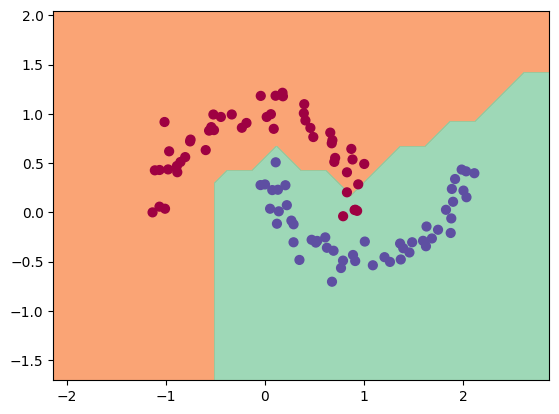

In [23]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())